<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funções e bibliotecas

In [1]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
from scipy.stats import shapiro
import seaborn as sns
import operator

In [2]:
def gerandodadosgaussianos(padrao, medias,covariancias,N,priors,plotar=True, seed=0,angulo=[0,0]):
    # Essa funcao gera um conjunto de dados simulados representando um
    # determinado numero de caracteristicas em um determinado numero de classes.
    # As classes possuem medias distintas e covariancias distintas. Os dados
    # seguem uma distribuicao gaussiana.
    # INPUT:
    # -medias =  classes x caracteristicas (matriz contendo as medias das
    #    caracteristica para cada classe)
    # -covariancia =  classes x caracteristicas x caracteristicas (matrizes de
    #    covariancia para cada classe)
    # -N = numero de padroes a serem gerados
    # -priors = classes x 1 (prior de cada classe: probabilidade de um padrao
    #    pertencer a cada classe)
    # - plotar = True (faz grafico - 2 ou tres dimensoes), False (nao faz grafico)
    # -seed = controle do seed na geracao de dados aleatorios
    # - angulo = angulo da visualizacao em caso de plot 3d.
    #
    # OUTPUT:
    # - dadossim=caracteristicas x padroes: dados simulados
    # - classessim= vetor contendo o numero da classe (de 0 ate C-1) de
    #     cada padrao simulado.
    M,L=np.shape(medias)
    if np.size(covariancias,axis=0)!=M |  np.size(covariancias,axis=1)!=L | np.size(covariancias,axis=2)!=L :
        print('Erro: confira a dimensao dos seus dados de input.')
        return
    if np.size(priors)!=M :
        print('Erro: confira a dimensao dos priors.')
        return
    if np.sum(priors)!=1 :
        print('Erro: confira os valores dos priors.')
        return
    Ni=tuple(np.round(priors*N))
    np.random.seed(seed)
    for i in range(M):
       if np.all(np.linalg.eigvals(covariancias[i]) > 0)==False :
           print('Erro: confira os valores da covariancia.')
       x=np.random.multivariate_normal(medias[i],covariancias[i],size=int(Ni[i]))
       if i==0:
           dadossim=x.T
           classessim=np.zeros(int(Ni[i]),)
       else:
           dadossim=np.concatenate((dadossim,x.T),axis=1)
           classessim=np.concatenate((classessim,np.zeros(int(Ni[i]),)+i),axis=0)

    if plotar:
        if L==2: #2 caracteristicas, plot 2d
            plt.figure()
            for i in range(M):
                plt.plot(dadossim[0,classessim==i],dadossim[1,classessim==i],'o',fillstyle='none')
            plt.xlabel('Dim 1')
            plt.ylabel('Dim 2')
            plt.show()
        elif L==3:
            plt.figure()
            ax=plt.axes(projection='3d')
            for i in range(M):
                ax.plot(dadossim[0,classessim==i],dadossim[1,classessim==i],dadossim[2,classessim==i],'o',fillstyle='none')
                ax.plot(padrao[0],padrao[1],padrao[2], 'o', fillstyle='full', color='red')
            ax.view_init(angulo[0],angulo[1])
            ax.set_xlabel('Dim 1')
            ax.set_ylabel('Dim 2')
            ax.set_zlabel('Dim 3')
            plt.show()
        else:
            print('Grafico é exibido apenas para 2 ou 3 dimensões')
    return dadossim, classessim

In [3]:
def t5_classbayesgauss(medias,covariancias,priors,x):
    #Classificador bayesiano para classes gaussianas.
    #INPUT
    # - medias M x L, cada linha é o vetor de medias de uma clase distinta (M)
    # - covariancias ( M x L x L):  covariancias (L x L) de cada classe
    # - priors (M x 1) priors de cada classe.
    # - x (N x L) = cada linha (N) é um padrao com L característica
    #OUTPUT
    # - probsposteriori (N x M) = probabilidade de cada padrao pertencer a cada classe
    # - classebayes (N x 1) = classe atribuida a cada padrao no classificador
    # bayesiano

    M,L=np.shape(medias)
    if np.size(covariancias,axis=0)!=M |  np.size(covariancias,axis=1)!=L | np.size(covariancias,axis=2)!=L :
        print('Erro: confira a dimensao dos seus dados de input.')
        return
    if np.size(priors)!=M :
        print('Erro: confira a dimensao dos priors.')
        return
    if np.sum(priors)!=1 :
        print('Erro: confira os valores dos priors.')
        return
    N,L2=np.shape(x)
    if L2!=L :
        print('Erro: confira a dimensao dos padroes.')
        return

    probsposteriori=np.zeros((N,M))
    classebayes=np.zeros(N,)
    for j in range(M): #classe
        A=np.linalg.inv(covariancias[j])
        for i in range(N): #padroes
            Norm=1/np.sqrt(((2*np.pi)**L)*np.linalg.det(covariancias[j]))
            xm=x[i]-medias[j]
            expoente=-(np.dot(xm,np.dot(A,xm.T)))/2
            probsposteriori[i,j]=priors[j]*Norm*np.exp(expoente)
    classebayes=np.argmax(probsposteriori,axis=1)
    return classebayes,probsposteriori

# Classificador Bayesiano

**1)** Classificando um padrão com um classificador Bayesiano. Suponha que estejamos trabalhando em um espaço tridimensional de características e queremos classificar padrões entre duas classes que possuem a mesma matriz de covariância, mas médias distintas:

*   Classe 1: $\vec{\mu} = (0,0,0)$
*   Classe 2: $\vec{\mu} = (0.5, 0.5, 0.5)$

A sua tarefa neste exercício é classificar o seguinte padrão $\vec{x} = (0.1, 0.5, 0.1)$ uma dessas duas classes.

**A)** Primeiramente, plote 600 pontos simulados, divididos entre essas duas classes no espaço das características. Para isso, use a função “gerandodadosgaussianos” disponível no github do curso (main.py). Inspecione esta função para usá-la corretamente. Plote no mesmo gráfico as duas classes simuladas e o ponto $\vec{x}$ (use um símbolo diverso para visualizar o ponto no meio dos dados simulados).

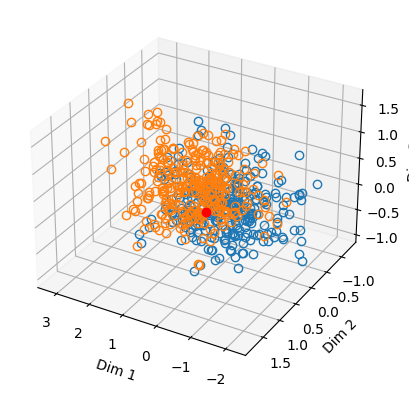

In [4]:
# definindo a matriz de covariancia e média das classes
cov = np.zeros((2, 3, 3))
cov[0, :, :] = np.array([[0.8, 0.01, 0.01], [0.01, 0.2, 0.01], [0.01, 0.01, 0.2]])
cov[1, :, :] = np.array([[0.8, 0.01, 0.01], [0.01, 0.2, 0.01], [0.01, 0.01, 0.2]])

medias = np.array([[0, 0, 0], [0.5, 0.5, 0.5]])
priors = np.array([1/2, 1/2])
padrao = np.array([0.1, 0.5, 0.1])

# gerando os dados gaussianos
dadossim, classessim = gerandodadosgaussianos(padrao, medias, cov, 600, priors, plotar=True, seed=0, angulo=[30, 120])